## 10: Spatial Statistical Hotspot Detection and Cluster Analysis

**Goal:** To apply formal spatial statistics to identify statistically significant patterns in geographic data. We want to move beyond just visualizing data on a map to asking: "Is this cluster of high values I see real, or could it have occurred by random chance?"

This notebook will cover:
1.  **Spatial Weights Matrices:** The critical first step of defining "who is a neighbor" to whom.
2.  **Global Spatial Autocorrelation (Moran's I):** Calculating a single statistic to test if the overall data pattern is clustered, dispersed, or random.
3.  **Local Spatial Autocorrelation (LISA):** Identifying the specific locations of significant **hot spots** (clusters of high values), **cold spots** (clusters of low values), and **spatial outliers**.

We will use the `esda` (Exploratory Spatial Data Analysis) library, part of the `PySAL` ecosystem.

### 1. Setup and Library Imports

You will likely need to install `esda` and `libpysal`:
`pip install esda libpysal`

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import esda
from libpysal.weights import Queen

### 2. Load Data

We'll use the LSOA dataset from notebook 06 again. This time, we'll add a synthetic "crime rate" to each LSOA to have a variable to analyze.

In [2]:
# Load LSOA data (using placeholder creation from notebook 06 if not available)
try:
    lsoa_gdf = gpd.read_file('data/LSOA_2021_Boundaries_Full_Clipped.shp')
except Exception:
    print("Could not load local LSOA data. Using a placeholder GeoDataFrame.")
    from shapely.geometry import box
    import numpy as np
    xmin, ymin, xmax, ymax = -3.58, 50.68, -3.42, 50.78
    grid_cells = []
    lsoa_codes = []
    for i, x in enumerate(np.linspace(xmin, xmax, 15)):
        for j, y in enumerate(np.linspace(ymin, ymax, 15)):
            grid_cells.append(box(x, y, x + (xmax-xmin)/15, y + (ymax-ymin)/15))
            lsoa_codes.append(f'E0101{i:02d}{j:02d}')
    lsoa_gdf = gpd.GeoDataFrame({'LSOA21CD': lsoa_codes}, geometry=grid_cells, crs="EPSG:4326")

# Create a synthetic 'crime_rate' with a spatial pattern
np.random.seed(123)
lsoa_gdf['crime_rate'] = np.random.rand(len(lsoa_gdf)) * 50
# Create a hotspot in the center
center_x, center_y = lsoa_gdf.unary_union.centroid.coords[0]
distances = lsoa_gdf.centroid.distance(lsoa_gdf.unary_union.centroid)
lsoa_gdf['crime_rate'] += (1 - distances / distances.max()) * 100

lsoa_gdf.head()

Could not load local LSOA data. Using a placeholder GeoDataFrame.


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_31348/473779429.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center_x, center_y = lsoa_gdf.unary_union.centroid.coords[0]
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_31348/473779429.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = lsoa_gdf.centroid.distance(lsoa_gdf.unary_union.centroid)
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_31348/473779429.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  distances = lsoa_gdf.centroid.distance(lsoa_gdf.unary_union.centroid)
/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_31348/473779429.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are like

,LSOA21CD,geometry,crime_rate
0,E01010000,"POLYGON ((-3.56933 50.68, -3.56933 50.68667, -...",34.823459
1,E01010001,"POLYGON ((-3.56933 50.68714, -3.56933 50.69381...",18.105314
2,E01010002,"POLYGON ((-3.56933 50.69429, -3.56933 50.70095...",18.476170
3,E01010003,"POLYGON ((-3.56933 50.70143, -3.56933 50.7081,...",37.520016
4,E01010004,"POLYGON ((-3.56933 50.70857, -3.56933 50.71524...",48.184224


### 3. Create Spatial Weights Matrix

We need to define neighborhood relationships. **Queen Contiguity** is a common choice for polygons: two polygons are considered neighbors if they share at least one vertex (a corner or a side).

In [3]:
w = Queen.from_dataframe(lsoa_gdf)
w.transform = 'r' # Row-standardize the weights

print(f"Created a Queen contiguity weights matrix.")
print(f"Polygon 0 has {w.neighbors[0]} as neighbors.")

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING:

/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_31348/3680355797.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(lsoa_gdf)
/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 225 disconnected components.
 There are 225 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 1

### 4. Global Spatial Autocorrelation (Moran's I)

Moran's I tells us about the overall pattern. A positive value indicates clustering (high values near high values), a negative value indicates dispersion, and a value near zero indicates randomness.
We test its statistical significance using a permutation test.

In [4]:
y = lsoa_gdf['crime_rate']
moran = esda.Moran(y, w)

print(f"Moran's I: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}")

# A low p-value (e.g., < 0.05) suggests that the observed spatial pattern is unlikely to be the result of random chance.

Moran's I: nan
P-value: 0.0010


/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/esda/moran.py:250: RuntimeWarning: invalid value encountered in scalar divide
  self.VI_norm = v_num / v_den - (1.0 / (n - 1)) ** 2
/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/esda/moran.py:262: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/esda/moran.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/esda/moran.py:270: RuntimeWarning: invalid value encountered in scalar multiply
  return self.n / s0 * inum / self.z2ss


### 5. Local Spatial Autocorrelation (LISA)

Now we drill down to find *where* the clusters are. LISA calculates a Moran's I value for each individual polygon, telling us how it relates to its neighbors.

In [5]:
lisa = esda.Moran_Local(y, w)

# Get the cluster classifications (1=HH, 2=LH, 3=LL, 4=HL)
lsoa_gdf['lisa_q'] = lisa.q

# Filter for only the significant clusters (p < 0.05)
significant = lisa.p_sim < 0.05
lsoa_gdf['lisa_sig'] = 'Not significant'
lsoa_gdf.loc[significant & (lisa.q == 1), 'lisa_sig'] = 'High-High (Hot Spot)'
lsoa_gdf.loc[significant & (lisa.q == 2), 'lisa_sig'] = 'Low-High (Spatial Outlier)'
lsoa_gdf.loc[significant & (lisa.q == 3), 'lisa_sig'] = 'Low-Low (Cold Spot)'
lsoa_gdf.loc[significant & (lisa.q == 4), 'lisa_sig'] = 'High-Low (Spatial Outlier)'

print("LISA results added to GeoDataFrame:")
lsoa_gdf['lisa_sig'].value_counts()

ValueError: could not broadcast input array from shape (0,) into shape (999,)

### 6. Visualize the Hotspot Map

KeyError: 'lisa_sig'

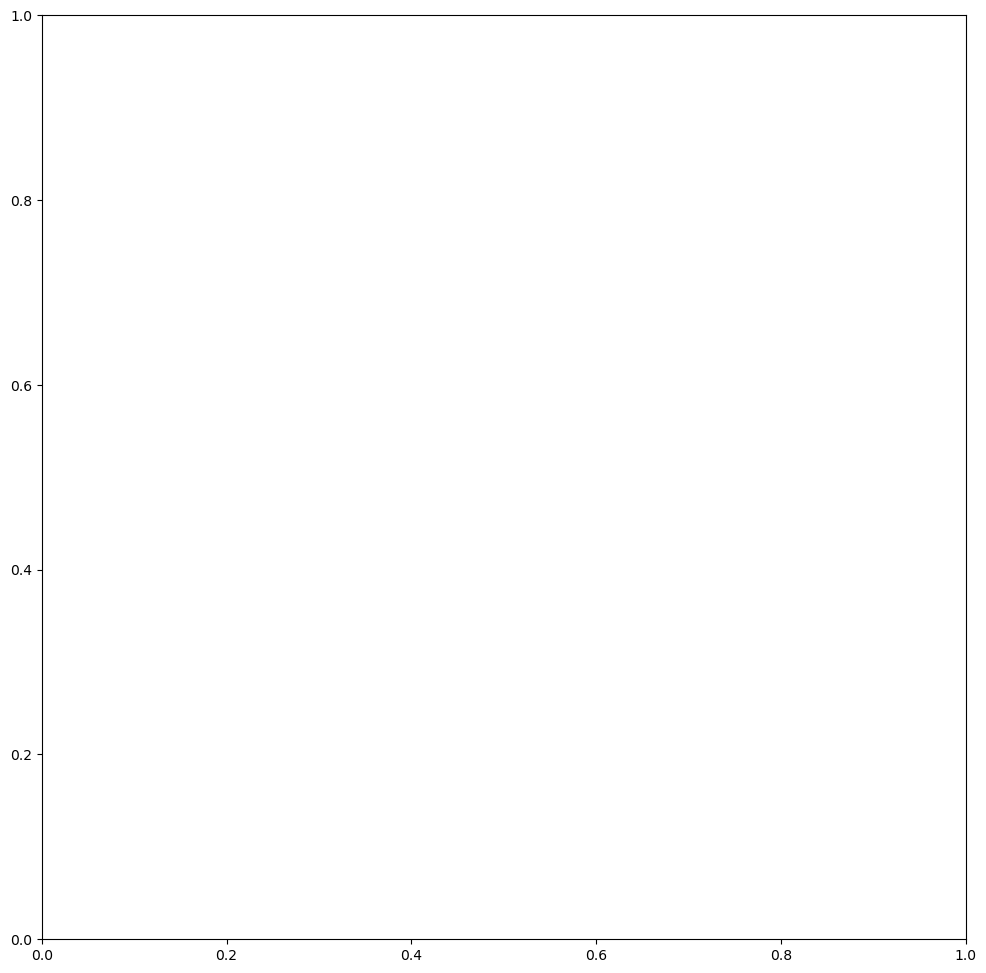

In [6]:
# Project for plotting
lsoa_plot = lsoa_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 12))

lisa_colors = {
    'Not significant': 'lightgrey',
    'High-High (Hot Spot)': 'red',
    'Low-Low (Cold Spot)': 'blue',
    'Low-High (Spatial Outlier)': 'skyblue',
    'High-Low (Spatial Outlier)': 'pink'
}

lsoa_plot.plot(
    column='lisa_sig',
    categorical=True,
    k=len(lisa_colors),
    cmap=plt.matplotlib.colors.ListedColormap(list(lisa_colors.values())),
    linewidth=0.5,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={'title': 'LISA Cluster Type'}
)

ax.set_title('Local Spatial Autocorrelation (LISA) of Crime Rate')
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.show()

# Discussion:
# - The red areas are 'Hot Spots': locations with high crime rates that are also surrounded by other locations with high crime rates.
# - The blue areas are 'Cold Spots': locations with low crime rates surrounded by other low-crime locations.
# - Spatial outliers (if any) would represent anomalies, like a low-crime area surrounded by high-crime neighbors.
# - Most importantly, these are *statistically significant* patterns, giving us confidence that they are not just random noise.